## 2D-3D registration

Setup: make sure python3.10 and virtualenv is installed. Then in the project folder, run:

```
python3.10 -m virtualenv venv-gsu
source venv-gsu/bin/activate
python -m pip install -r requirements.txt
git submodule update --init
```

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=400)
from numpy.linalg import svd, norm, lstsq, inv, eigh, det, eigvalsh, eigvals
from tqdm.notebook import tqdm
from pathlib import Path
import time
import cv2

from matplotlib import pyplot as plt
%matplotlib widget

import scipy.optimize
from triangulation_relaxations import so3
from triangulation_relaxations.se3 import Se3
from triangulation_relaxations import geometry

from colmap.scripts.python.read_write_model import read_model, qvec2rotmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load COLMAP data

Download a dataset from https://www.cs.ubc.ca/~kmyi/imw2020/data.html, example uses "Reichstag" which is the smallest one

In [5]:
def params_to_intrinsics(pars):
    return np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])

def get_intrinsics(camera):
    pars = camera.params
    if camera.model == 'SIMPLE_RADIAL':
        return np.array([
            [pars[0], 0, pars[1]],
            [0, pars[0], pars[2]],
            [0, 0, 1],
        ])
    else:
        return params_to_intrinsics(pars)

dataset = "reichstag"
src = Path(f'/home/linus/workspace/data/{dataset}/dense/sparse')
images_dir = Path(f'/home/linus/workspace/data/{dataset}/dense/images')

cameras, images, points = read_model(path=src, ext='.bin')

view_inds = sorted(images.keys())
point_inds = np.array(list(points.keys()))
intrinsics = np.array([get_intrinsics(cameras[images[i].camera_id]) for i in view_inds])
heights = [cameras[images[i].camera_id].height for i in view_inds]
widths = [cameras[images[i].camera_id].width for i in view_inds]

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

ydown2zup = np.array([
    [0, 0, 1, 0],
    [-1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]
])

# transform points to z-up convention
colmap_points = np.array([ydown2zup[:3, :3] @ point.xyz for point in points.values()])
colmap_colors = np.array([point.rgb / 255. for point in points.values()])

r = np.array([qvec2rotmat(images[i].qvec) for i in view_inds])
t = np.array([images[i].tvec for i in view_inds])

# transform poses to world-to-camera and z-up convention
colmap_poses = Se3(ydown2zup[:3, :3]) * Se3(r, t).inverse()

Cameras: 75
Images: 75
3D points: 17823


Text(0.5, 1.0, 'GT pose')

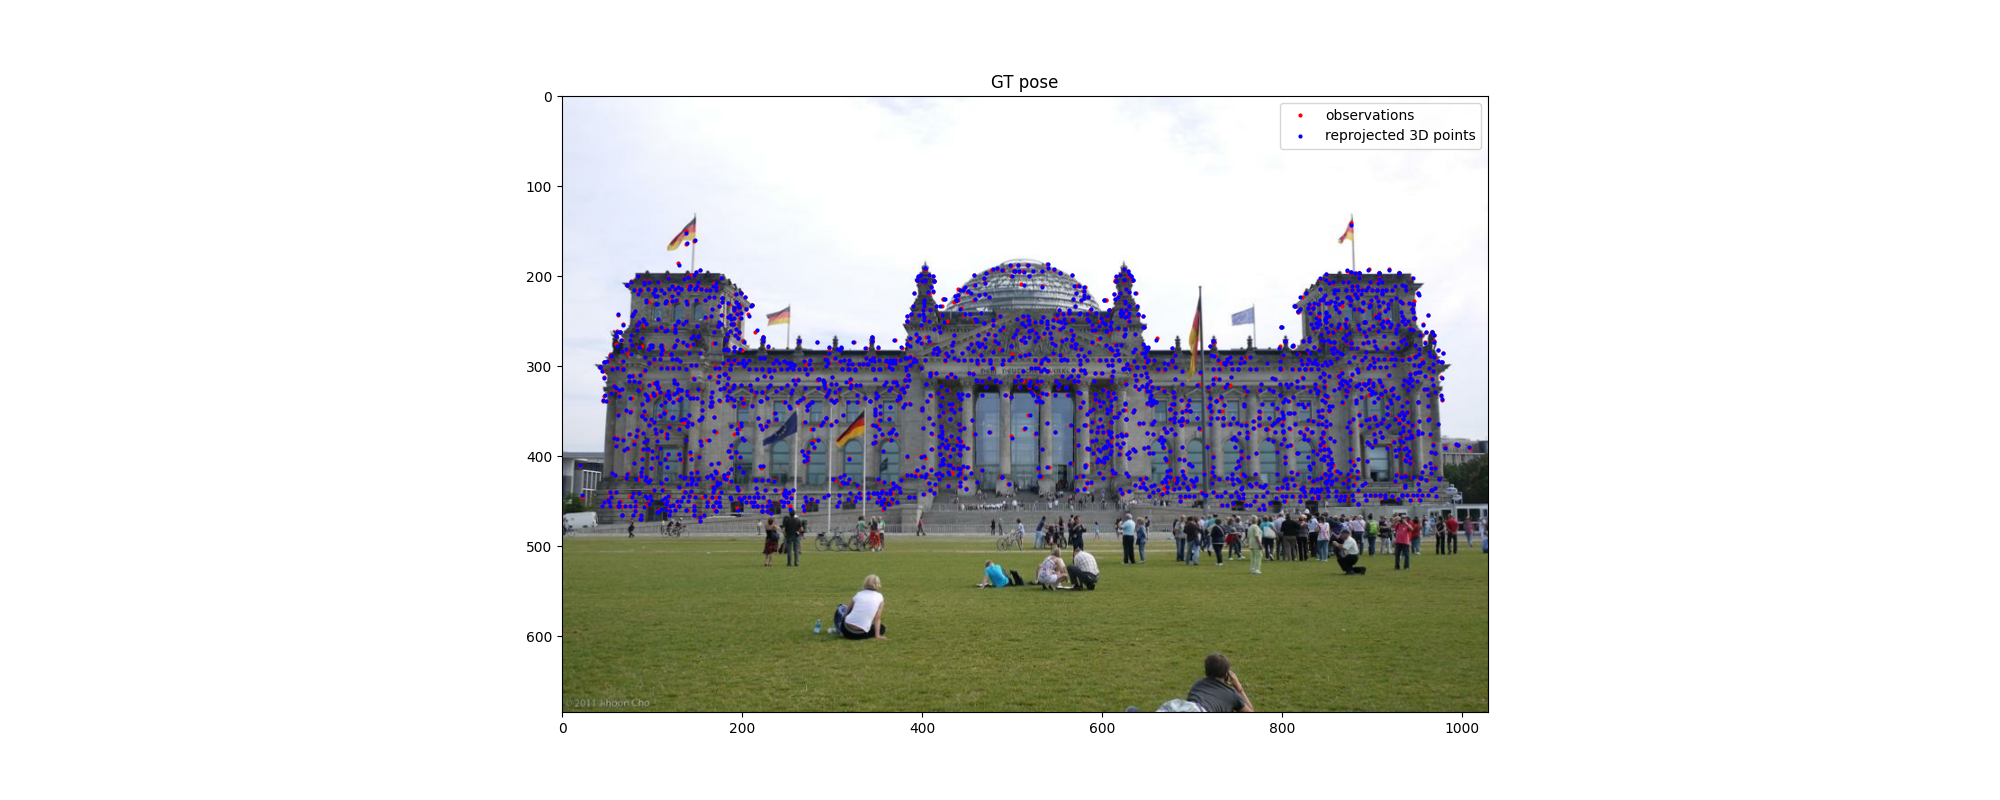

In [10]:
image_index = 2
image_id = view_inds[image_index]

observations = np.array([images[image_id].xys[i] for i, point_id in enumerate(images[image_id].point3D_ids) if point_id >= 0])

points_in_image = np.array([points[i].xyz for i in images[image_id].point3D_ids if i >= 0])
colors_in_image = np.array([points[i].rgb for i in images[image_id].point3D_ids if i >= 0]) / 255
points_3d = np.array([colmap_points[list(point_inds).index(i)] for i in images[image_id].point3D_ids if i >= 0])

reprojected_points = geometry.reproject(points_3d, colmap_poses[image_index], intrinsics[image_index])

image = cv2.imread(str(images_dir / images[image_id].name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.imshow(image)
ax.plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax.plot(reprojected_points[:, 0], reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax.legend()
ax.set_title('GT pose')

## Visualize reconstruction problem with blender (optional)

Setup:
* install blender from https://www.blender.org/ (tested with version 3.4.1)
* `blender_notebook install --kernel-name "blender-gsu" --blender-exec /home/linus/workspace/blender/blender-3.4.1-linux-x64/blender`
* select `blender-gsu` as notebook kernel (might require restarting the editor)

In [22]:
import plot_reconstruction
from plot_reconstruction import plot_cameras, make_line, Colors
import blender_plots as bplt

# plot 3D points and cameras
image_depth = 0.25
plot_reconstruction.setup_scene(floor_z=-1.1)
bplt.Scatter(colmap_points, color=colmap_colors, marker_type='spheres', name='colmap points', radius=0.03)
plot_cameras(colmap_poses, intrinsics, heights, widths, image_depth=image_depth)

In [21]:
# plot some observations
bplt.Scatter(
        np.einsum('...ij, ...j->...i', colmap_poses[image_index].T, geometry.homogenize(np.einsum('...ij, ...j->...i', np.linalg.inv(intrinsics[image_index]), geometry.homogenize(observations) * image_depth)))[:, :-1],
        marker_type="cubes",
        color=colors_in_image,
        size=np.array([0.05, 0.05, 0.005]) * 0.05,
        marker_rotation=colmap_poses[image_index].R,
        name="observations"
)
for i, point in enumerate(points_in_image):
    if i % 100 == 0:
        make_line(
                colmap_poses[image_index].t,
                (colmap_poses[image_index].T @ geometry.homogenize(np.linalg.inv(intrinsics[image_index]) @ geometry.homogenize(observations[i]) * 100))[:-1],
                width=0.005,
                color=np.ones(3) * 0.1,
                name=f'observation_{i}',
        )

### Optimization example with Numpy/Scipy

In [23]:

def x_to_pose(x):
    return Se3(so3.rotvec_to_r(x[:3]), x[3:])

def pose_to_x(pose):
    return np.concatenate([so3.r_to_rotvec(pose.R), pose.t])

def get_reprojection_residuals(pose, points, observations, intrinsics):
    reprojected_points = geometry.reproject(points, pose, intrinsics)
    return ((observations - reprojected_points) ** 2).sum(axis=1)

# Local optimization starting from another pose
pose0_index = 3
pose0 = colmap_poses[pose0_index]

results = scipy.optimize.least_squares(
    lambda x: get_reprojection_residuals(x_to_pose(x), points_3d, observations, intrinsics[image_index]),
    pose_to_x(pose0),
    ftol=1e-16,
    gtol=1e-16
)
pose_optimized = x_to_pose(results.x)

/home/linus/workspace/jaxopt-3D-reconstruction/venv-gsu/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "
/home/linus/workspace/jaxopt-3D-reconstruction/venv-gsu/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: Setting `gtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


In [24]:
plot_cameras(
    pose0[None],
    intrinsics[image_index][None],
    [heights[image_index]],
    [widths[image_index]],
    frustum_color=np.ones(3) * 0.9, fill_color=np.ones(3) * 0.1, name="init pose"
)

plot_cameras(
    pose_optimized[None],
    intrinsics[image_index][None],
    [heights[image_index]],
    [widths[image_index]],
    frustum_color=Colors.blue1, fill_color=Colors.blue2, name="optimized pose"
)

  0%|          | 0/102 [00:00<?, ?it/s]

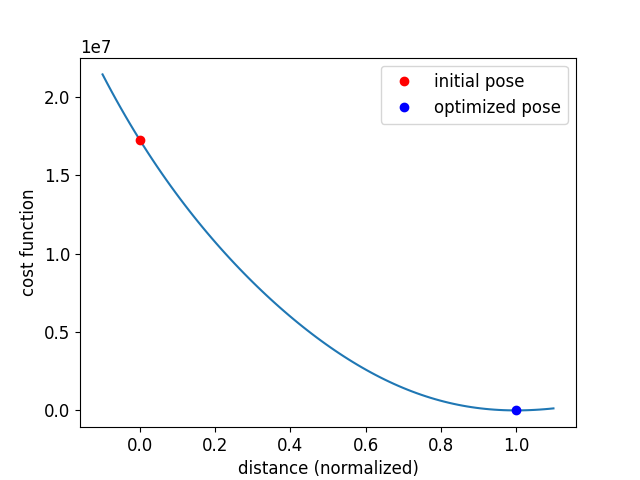

In [25]:
def plot_costs(ax, pose0, pose1, points, observations, intrinsics, eps=0.1, n=1000, label0='', label1=''):
    """Plot cost function when interpolating between pose0 and pose1"""
    taus = np.linspace(-eps, 1 + eps, n)
    index_0, index_1 = np.searchsorted(taus, [0, 1])
    taus = np.insert(taus, [index_0, index_1], [0, 1])
    index_1 += 1 # compensate for the insertion of 0

    objective_values = [
        get_reprojection_residuals(
            pose=Se3( # interpolate with axis-angle
                (pose0.q ** (1 - tau) * pose1.q ** tau).R,
                pose0.t * (1 - tau) + pose1.t * tau
            ),
            points=points,
            observations=observations,
            intrinsics=intrinsics,
        ).sum()
        for tau in tqdm(taus)
    ]
    ax.plot(taus, objective_values)
    ax.plot(0, objective_values[index_0], 'o', color='red', label=label0)
    ax.plot(1, objective_values[index_1], 'o', color='blue', label=label1)

# increase plot font size
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 1)
plot_costs(ax, pose0, pose_optimized, points_3d, observations, intrinsics[image_index], label0='initial pose', label1='optimized pose', n=100)
# ax.axhline(results_gt.cost, color='k', linestyle='--')
ax.set_xlabel('distance (normalized)')
ax.set_ylabel('cost function')
ax.legend()

Text(0.5, 1.0, 'Optimized pose')

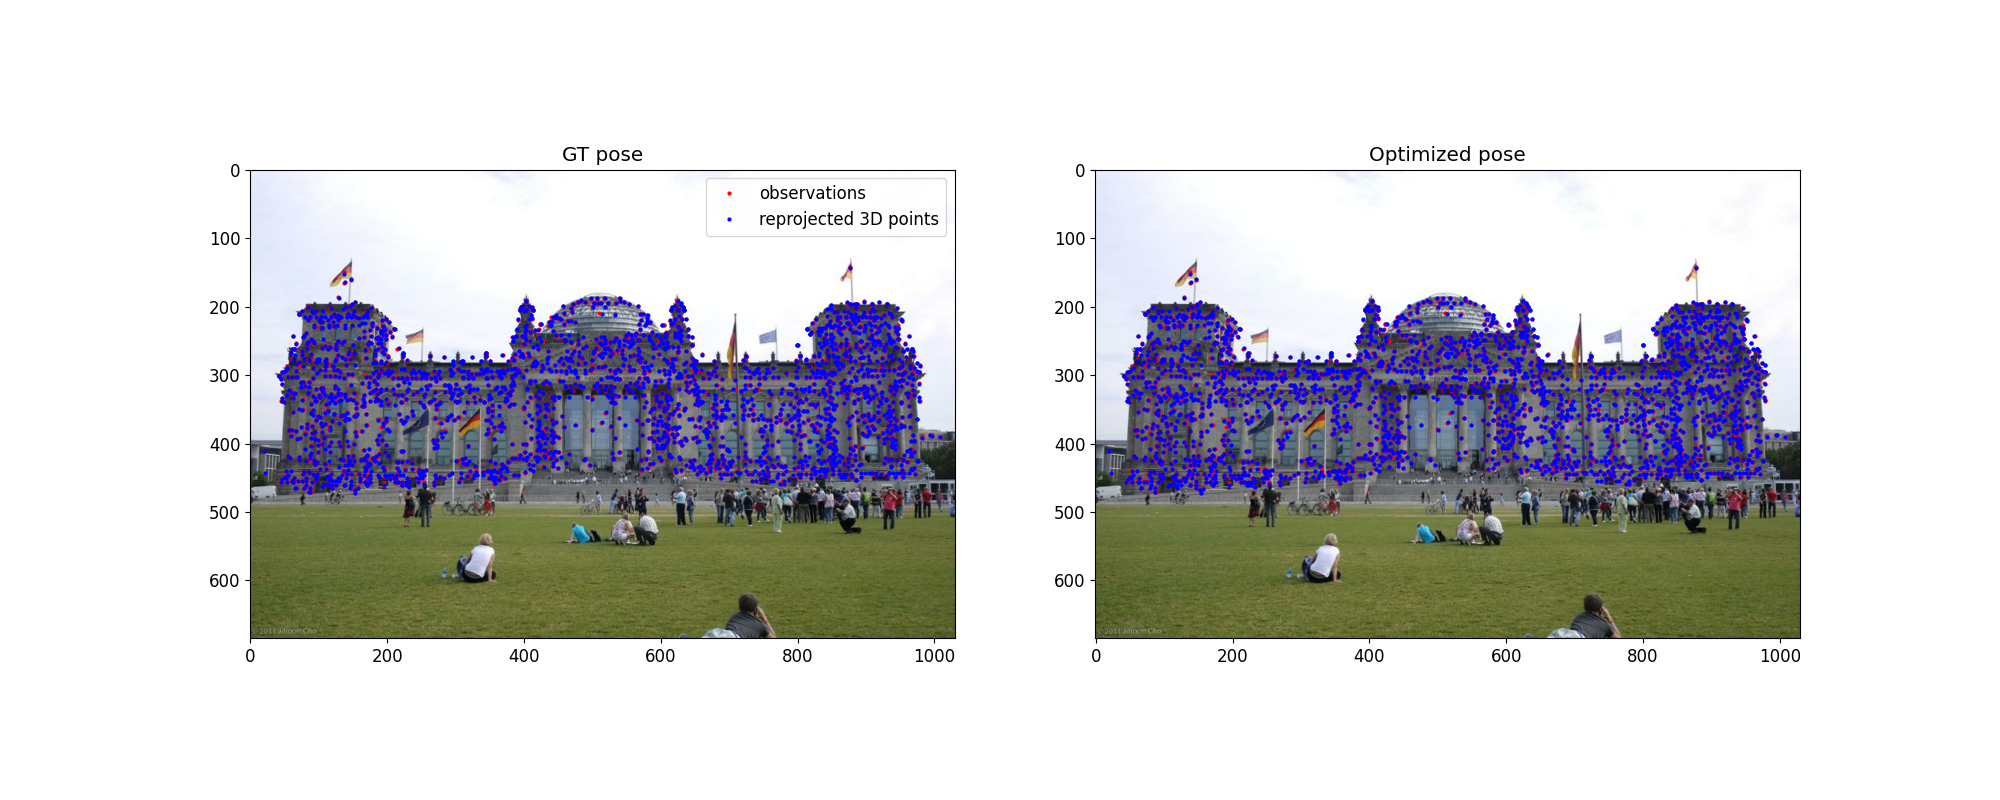

In [26]:
import cv2
reprojected_points = geometry.reproject(points_3d, colmap_poses[image_index], intrinsics[image_index])
optimized_reprojected_points = geometry.reproject(points_3d, pose_optimized, intrinsics[image_index])

image = cv2.imread(str(images_dir / images[image_id].name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].imshow(image)
ax[0].plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax[0].plot(reprojected_points[:, 0], reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax[0].legend()
ax[0].set_title('GT pose')

ax[1].imshow(image)
ax[1].plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax[1].plot(optimized_reprojected_points[:, 0], optimized_reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax[1].set_title('Optimized pose')